In [1]:
%matplotlib inline
import os
import re
from collections import Counter
import pandas as pd
import numpy as np
from matplotlib.ticker import MaxNLocator, StrMethodFormatter
import matplotlib.pyplot as plt

In [2]:
import pyspark
import pyspark.sql
from pyspark.sql import *
from pyspark.sql.functions import *

conf = pyspark.SparkConf().setMaster("local[*]").setAll([
                                   ('spark.executor.memory', '12g'),
                                   ('spark.driver.memory','12g'),
                                   ('spark.driver.maxResultSize', '4G'),
                                   ('spark.executor.extrajavaoptions', '-Xmx1024m')
                                  ])
# create the session
spark = SparkSession.builder.config(conf=conf).getOrCreate()

# create the context
sc = spark.sparkContext

# FIX for Spark 2.x
locale = sc._jvm.java.util.Locale
locale.setDefault(locale.forLanguageTag("en-US"))

# get Spark UI link
spark

In [3]:
posts = spark.read.json("./data/messages.json.gz")
scores = spark.read.json("./data/score.json.gz")

In [4]:
posts = posts.limit(100)

In [5]:
def jaccard_similarity(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    return len(s1.intersection(s2)) / len(s1.union(s2))

In [6]:
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer, CountVectorizerModel

In [7]:
# No longer out of memory, but takes more time
# tokenize and remove stop words using spark ml utilities
regexTokenizer = RegexTokenizer(inputCol='body', outputCol='words', pattern='\\W')
stop_remover = StopWordsRemover(inputCol='words', outputCol='filtered words')

posts_tokenized = regexTokenizer.transform(posts).drop('body').sort(asc('subreddit'))
posts_transformed = stop_remover.transform(posts_tokenized).drop('words')

In [19]:
posts_transformed.withColumn('string', concat_ws(' ', 'filtered words')).show()

+--------------------+-------+---------------+--------------------+--------------------+
|              author|     id|      subreddit|      filtered words|              string|
+--------------------+-------+---------------+--------------------+--------------------+
|PM-ME-YOUR-PY-SCRIPT|cqug953|  AdviceAnimals|              [know]|                know|
|   backwoodsofcanada|cqug91n|  AdviceAnimals|[something, hear,...|something hear lo...|
|              Eztec8|cqug9ak|  AdviceAnimals|    [fucking, sorry]|       fucking sorry|
|       ConnorWolf121|cqug9fi| DestinyTheGame|             [thank]|               thank|
|             mathees|cqug9hl| DestinyTheGame|[4, boxes, every,...|4 boxes every 2 m...|
|          Fahrowshus|cqug9et| DestinyTheGame|[always, ask, peo...|always ask people...|
| DragonTwinSummoners|cqug9ev| DestinyTheGame|   [primary, weapon]|      primary weapon|
|            Roxas146|cqug97y|          DotA2|[nice, content, s...|nice content stea...|
|         lemankimask

In [8]:
cv = CountVectorizer(inputCol='filtered words', outputCol='features', vocabSize=1 << 30)
model = cv.fit(posts_transformed)

In [13]:
%%time
# No longer out of memory, but takes more time
words_to_remove = model.vocabulary[50000:]
non_freq_remover = StopWordsRemover(inputCol='filtered words', outputCol='frequent words', stopWords=words_to_remove)
posts_frequent = non_freq_remover.transform(posts_transformed).drop('filtered words')
words_reps_df = posts_frequent.groupby('subreddit') \
                              .agg(flatten(collect_set('frequent words')).alias('words_rep'))
words_reps = [set(row.words_rep) for row in words_reps_df.collect()]

CPU times: user 32.7 ms, sys: 33.5 ms, total: 66.1 ms
Wall time: 17.5 s


In [14]:
# concatenate all the posts bodies in the same subreddit
posts_concat = posts.groupby('subreddit') \
                    .agg(concat_ws(' ', collect_list('body')).alias('concat_body')) \
                    .sort(asc('subreddit'))

In [23]:
all_posts_concat = posts_concat.select(concat_ws(' ', collect_list('concat_body')).alias('concat_body'))

In [26]:
all_body = all_posts_concat.collect()[0].concat_body

In [76]:
all_words = set(re.split('\\W', all_body.lower()))
print('' in all_words)
all_words = filter(None, all_words)
stop_words = set(stop_remover.loadDefaultStopWords('english'))
counter = Counter(all_words)
words_sorted = sorted(counter, key=counter.get, reverse=True)
words_sorted = [w for w in words_sorted if w not in stop_words]

True


In [75]:
for word in words_sorted:
    if word not in model.vocabulary:
        print(word)

수정의
여인
수정


In [24]:
%%time
words_reps_a = []
freq_words = set(model.vocabulary[:50000])

for row in posts_concat.collect():
    # split all the posts bodies by \W
    words = set(re.split('\\W', row.concat_body.lower()))
    # retain the 50000 most frequent words
    # since frequent words will not include stop words
    # there will be no stop words in the representation
    words_rep = [w for w in words if w in freq_words]
    words_reps_a.append(words_rep)
    break

CPU times: user 6.47 ms, sys: 3.38 ms, total: 9.85 ms
Wall time: 123 ms


In [12]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [13]:
%%time
jaccards = np.zeros((15, 15))

for i, words_rep_f in enumerate(words_reps):
    for j, words_rep_s in enumerate(words_reps):
        jaccards[i, j] = jaccard_similarity(words_rep_f, words_rep_s)

CPU times: user 2min 33s, sys: 1.68 s, total: 2min 35s
Wall time: 2min 41s


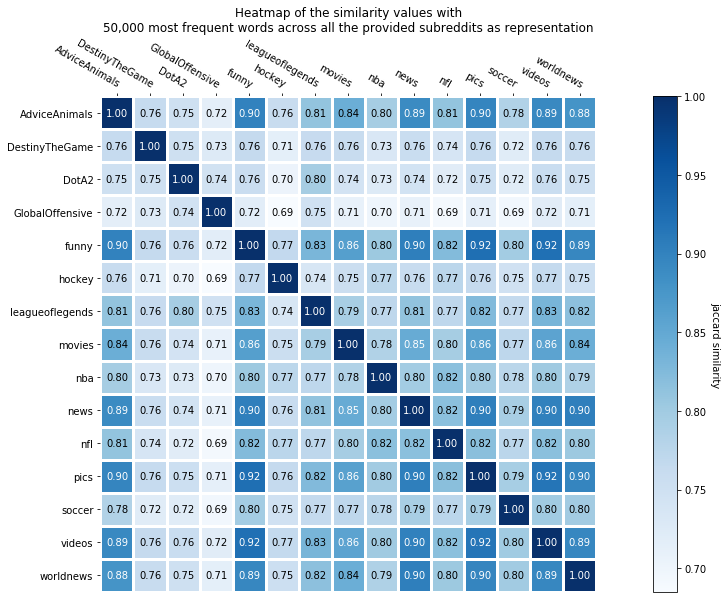

In [15]:
fig, ax = plt.subplots(figsize=(16, 8))
subreddits = ['AdviceAnimals', 'DestinyTheGame', 'DotA2', 'GlobalOffensive',
              'funny', 'hockey', 'leagueoflegends', 'movies', 'nba', 'news',
              'nfl', 'pics', 'soccer', 'videos', 'worldnews']

im, cbar = heatmap(jaccards, subreddits, subreddits, ax=ax,
                   cmap="Blues", cbarlabel="jaccard similarity")
texts = annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()
plt.title('Heatmap of the similarity values with\n50,000 most frequent words across all the provided subreddits as representation')
plt.show()